In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from scipy import special
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn import base, metrics, decomposition, preprocessing

## Graph Mining Project Update Presentation: Anomaly Detection in Financial Transaction Graphs

This is a document detailing the work I've done learning about anomaly and outlier detection in financial transaction graphs.

## Recap

Anomaly detection is important in several areas, including but not limited to:

- Financial Fraud Detection
- Network Security
- Event Detection

There are several different methods to finding anomalies which make use of graphs, each at different scopes of the graph. An outlier can be global, local, or community-scoped. The basic goal of outlier detection is to identify those nodes or edges which are far outside the norm of the dataset.

## What I've Worked On

In the past few weeks I've implemented the following algorithms, chosen a metric to measure success, and fit these models to a dataset of labeled bitcoin transactions.

### Evaluation Metric

By definition, outliers are rare. Because of this, one might think that a baseline model that predicts that there are zero outliers ever could be a sufficient solution. While this model might give very good accuracy (correct predictions over total predictions), it is - understandably - a poor outlier detection algorithm as it does not detect any outliers. Instead, we will be using the precision (percentage of nodes flagged that are actual anomalies) and recall (percentage of real anomalies were actually flagged) of the model as our outlier threshold changes to measure the success of the model. Our metric for success will be the area under the curve of the precision recall curve.

In [2]:
def evaluate(gt, pred):
    precision, recall, _ = metrics.precision_recall_curve(gt, pred, pos_label=1)
    precision[-1] = precision[-2]
    precision[0] = precision[1 % len(recall)]
    auc = metrics.auc(recall, precision)
    fig, ax = plt.subplots()
    fig.suptitle("Precision Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.plot(recall, precision)
    return auc, ax

## Data

This data is a bitcoin financial transaction network labeled with legal and illegal nodes. Each node is composed of 167 numeric attributes. The data is available on Kaggle [here](https://www.kaggle.com/ellipticco/elliptic-data-set).

In [3]:
data_root = "../data/"

In [4]:
filepath = os.path.join(data_root, "elliptic_bitcoin_dataset/")
edgelist = pd.read_csv(os.path.join(filepath, "elliptic_txs_edgelist.csv"))
features = pd.read_csv(os.path.join(filepath, "elliptic_txs_features.csv"), header = None)
classes = pd.read_csv(os.path.join(filepath, "elliptic_txs_classes.csv"))

To reduce the time of training quite a bit, I performed some dimensionality reduction with a pricipal component analysis. This changed the number of attributes from 167 down to 30 while keeping 90\% of the variance. Additionally, some of the dataset is not known. For training, we remove these data points from consideration.

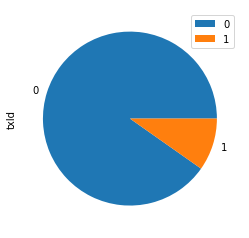

In [5]:
pca = decomposition.PCA(n_components=0.9)
reduced_features = pd.DataFrame(pca.fit_transform(features.drop(columns=0).values))
reduced_features["txId"] = features[0]
known_classes = classes[classes['class'] != "unknown"].copy()
known_classes['class'] = 2 - known_classes['class'].astype('int32')
known_classes.groupby('class').agg('count').plot.pie(y='txId')
plt.show()

Notice that our data is rather imbalanced. The anomalous nodes are around 10\% of the data. A normal accuracy metric would give 90\% accuracy to a model that just predicted there are zero outliers in the data. While 90\% accuracy might sound good, it will not be a good outlier detection model.

In [6]:
D = pd.merge(known_classes, reduced_features, on="txId", how="inner")
D_ids = set(D['txId'])
edge_ids = set(edgelist['txId1']).union(set(edgelist['txId2']))
ids = D_ids.intersection(edge_ids)
known_edgelist = edgelist[ edgelist['txId1'].isin(ids) & edgelist['txId2'].isin(ids)]
D = D[D['txId'].isin(ids)]
gt = D[["txId", "class"]]
train = D.drop(columns=["txId", "class"])

In [7]:
G = nx.from_pandas_edgelist(known_edgelist, source="txId1", target="txId2", create_using=nx.MultiGraph)
G.add_nodes_from(ids)
nx.set_node_attributes(G=G, name="D", values=dict(zip(gt["txId"], train.values)))

## Models

### Baseline

Our baseline model always predicts 0 chance of outliers.

In [8]:
class Baseline(base.BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X = None, y = None):
        return self
    
    def predict_proba(self, X = None, y = None):
        ret = np.zeros(len(X))
        ret[0] = 1
        return ret

Wall time: 654 µs
Baseline AUC: -0.00e+00


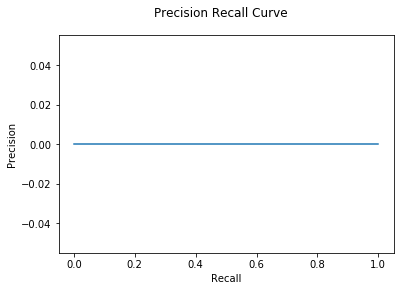

In [9]:
knn = 20
M = Baseline()
%time pred_probs = M.predict_proba(train)
auc, ax = evaluate(gt["class"], pred_probs)
print("Baseline AUC: {:.2e}".format(auc))
plt.show()

Notice that because there are no true positives in the baseline model, the AUC of the precision recall graph will always be 0.

### Global Outlier Detection (GLODA)

Global outlier detection does not take into account the structure of the graph, although the strategy used to identify global outliers does make use of graph mining in a different way. By placing the training data in its d-dimensional space and identifying the k-nearest neighbors of each data point, we create a graph of closely related data points. The local outlier factor, or LOF, is then computed for each node $n$ based on how many of its k-nearest neighbors have node $n$ as a k-nearest neighbor as well. Fewer in common nearest neighbors leads to a higher outlier factor. This algorithm naturally prefers clustered behavior.

In [10]:
class GLODA(base.BaseEstimator):
    def __init__(self):
        self.clf_ = LocalOutlierFactor()
    
    def fit(self, X = None, y = None):
        self.clf_.fit(X)
        return self
    
    def predict_proba(self, X = None, y = None):
        S = preprocessing.MinMaxScaler()
        self.clf_.fit(X)
        result = self.clf_.negative_outlier_factor_
        result_scaled = S.fit_transform(result[np.newaxis].T).T[0]
        return result_scaled

Wall time: 2min 23s
GLODA AUC: 1.15e-01


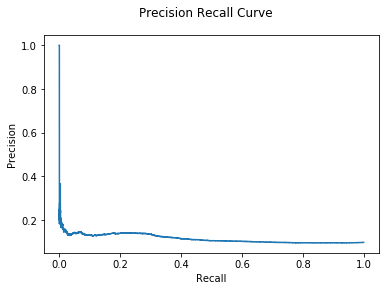

In [11]:
knn = 20
M = GLODA()
%time pred_probs = M.predict_proba(train)
auc, ax = evaluate(gt["class"], pred_probs)
print("GLODA AUC: {:.2e}".format(auc))
plt.show()

Observe that as the outlier threshold lessens, more true outliers are identified, but also several false positives, causing the precision of the model to rapily decline.

### Direct Neighbor Outlier Detection (DNODA)

DNODA compares each node's data to its direct neighbors. nodes that have an abnormally large distance from its neighbors in the graph are considered more anomalous. 

In [12]:
class DNODA(base.BaseEstimator):
    def __init__(self, G):
        self.G_ = G
    
    def fit(self, X = None, y = None):
        return self
    
    def predict_proba(self, X = None, y = None):
        distances = np.zeros(len(y))
        node_data = nx.get_node_attributes(G=self.G_, name="D")
        for idx, v in enumerate(y):
            p0 = node_data[v]
            for u in self.G_.neighbors(v):
                p1 = node_data[u]
                distances[idx] += np.sqrt(np.sum(np.square(p0 - p1)))
            distances[idx] /= self.G_.degree(v) + 1
        S = preprocessing.MinMaxScaler()
        scaled_distances = S.fit_transform(-distances[np.newaxis].T).T[0]
        return scaled_distances

Wall time: 3.99 s
DNODA AUC: 1.85e-01


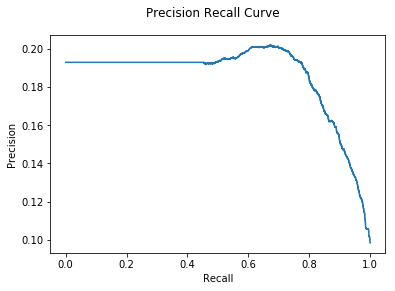

In [13]:
M = DNODA(G)
%time pred_probs = M.predict_proba(y=gt['txId'])
auc, ax = evaluate(gt["class"], pred_probs)
print("DNODA AUC: {:.2e}".format(auc))
plt.show()

Right now we can get better results with the DNODA algorithm than with GLODA. Let's see if CNA gives even more improvement:

### Community Outlier Detection (CNA)

CNA is extremely similar to DNODA, but instead of comparing each node to just its direct neighbors, the algorithm first runs a community clustering algorithm then performs an average distance calculation to all of the other nodes in its community. If a node has a high distance from the other nodes in its community it is considered more anomalous.

For simplicity's sake, we are simply using a label propagation community clustering algorithm, although any community algorithm would work here.

In [14]:
class CNA(base.BaseEstimator):
    def __init__(self, G):
        self.G_ = G
    
    def fit(self, X, y = None):
        return self
    
    def predict_proba(self, X = None, y = None):
        distances = np.zeros(len(y))
        node_data = nx.get_node_attributes(G=self.G_, name="D")
        communities = nx.algorithms.community.label_propagation_communities(self.G_)
        lookup = dict(zip(y.to_numpy(), range(len(y))))
        for c in communities:
            for v in c:
                idx = lookup[v]
                p0 = node_data[v]
                for u in c:
                    if v == u: continue
                    p1 = node_data[u]
                    distances[idx] += np.sqrt(np.sum(np.square(p0 - p1)))
                distances[idx] /= len(c)
        S = preprocessing.MinMaxScaler()
        scaled_distances = S.fit_transform(-distances[np.newaxis].T).T[0]
        return scaled_distances

Wall time: 5min 9s
CNA AUC: 1.85e-01


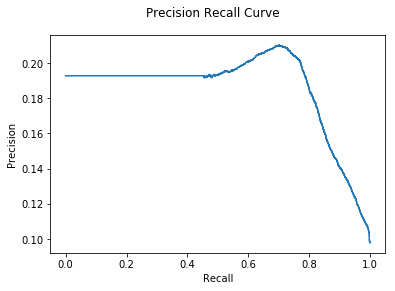

In [15]:
M = CNA(G)
%time pred_probs = M.predict_proba(y = gt['txId'])
auc, ax = evaluate(gt["class"], pred_probs)
print("CNA AUC: {:.2e}".format(auc))
plt.show()

Right now we are seeing basically identical performance from the CNA and DNODA algorithm.

### Hybrid Model

In a large real-world graph, there will most likely be anomalous nodes from the direct neighbor, community, and global scope. To identify outliers at each of these scopes, let's aggregate each algorithm's "outlier score" per node (low meaning average, high meaning anomalous) and see which nodes jump out at us. We will aggregate both using `sum` and `min`.

In [16]:
class Hybrid(base.BaseEstimator):
    def __init__(self, models, agg_fun = lambda x: np.sum(x, axis=0)):
        self.models_ = models
        self.agg_fun_ = agg_fun
    
    def fit(self, X, y = None):
        for m in self.models_:
            m.fit(X, y)
        return self
    
    def predict_proba(self, X, y = None):
        return self.agg_fun_([m.predict_proba(X, y) for m in self.models_])

Wall time: 7min 36s
Hybrid Sum AUC: 2.03e-01


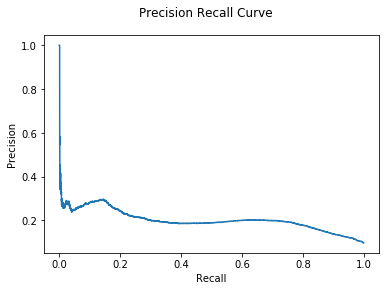

In [17]:
M = Hybrid(models = [GLODA(), DNODA(G), CNA(G)])
%time pred_probs = M.predict_proba(X = train, y = gt['txId'])
auc, ax = evaluate(gt["class"], pred_probs)
print("Hybrid Sum AUC: {:.2e}".format(auc))
plt.show()

Wall time: 4min 43s
Hybrid Min AUC: 2.01e-01


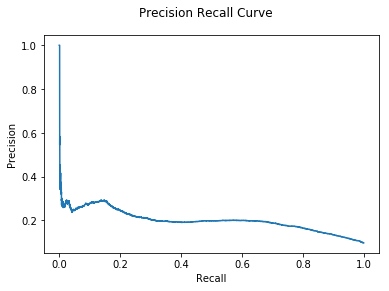

In [18]:
M = Hybrid(models = [GLODA(), DNODA(G), CNA(G)], agg_fun=lambda x: np.min(x, axis=0))
%time pred_probs = M.predict_proba(X = train, y = gt['txId'])
auc, ax = evaluate(gt["class"], pred_probs)
print("Hybrid Min AUC: {:.2e}".format(auc))
plt.show()

We see that using a Hybrid model gives some small improvement, although there is no clear difference between the aggregation strategies.

## What's Next

While the GLODA, DNODA, and CNA algorithms are implemented, they are not yet very good predictive models. Currently, the model naively measures the average distance from one node to each neighbor. This may not be ideal as illegal behavior does not necessarily have to be extrodinarily far from the norm. There may be some more nuanced patterns of illicit behavior that we can better capture with a classifier. The next step of the project is to include a classifier that takes aggregated data at the global, local, and community level to make more accurate predictions.